# Validación Honesta vs No Honesta

Autor: Daniel Requena Moreno       daniel.requena.bcn@gmail.com

## Librerías

In [25]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Cargar y explorar el dataset

Dimensiones del dataset: (569, 32)

Primeras filas del dataset:
         ID diagnosis  mean_radius  mean_texture  mean_perimeter  mean_area  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   mean_smoothness  mean_compactness  mean_concavity  mean_concave_points  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

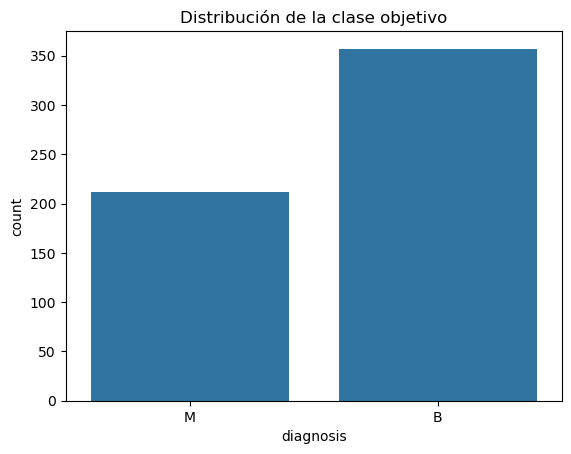

ValueError: could not convert string to float: 'M'

<Figure size 1200x1000 with 0 Axes>

In [27]:

# Cargar el dataset desde el archivo CSV
ruta_csv = 'datasets/breast/wdbc.data'

columnas = ['ID', 'diagnosis', 'mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 
            'mean_smoothness', 'mean_compactness', 'mean_concavity', 'mean_concave_points',
            'mean_symmetry', 'mean_fractal_dimension', 'se_radius', 'se_texture', 
            'se_perimeter', 'se_area', 'se_smoothness', 'se_compactness', 'se_concavity', 
            'se_concave_points', 'se_symmetry', 'se_fractal_dimension', 'worst_radius', 
            'worst_texture', 'worst_perimeter', 'worst_area', 'worst_smoothness', 
            'worst_compactness', 'worst_concavity', 'worst_concave_points', 'worst_symmetry', 
            'worst_fractal_dimension']  # Cambiar según las columnas del dataset

# Cargar el archivo
df = pd.read_csv('datasets/breast/wdbc.data', header=None, names=columnas)

# Inspeccionar el dataset
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas del dataset:")
print(df.head())
print("\nDescripción estadística de las características:")
print(df.describe())

# Verificar si hay valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())

# Distribución de la clase objetivo
print("\nDistribución de la variable 'diagnosis':")
print(df['diagnosis'].value_counts())



## Preparación del dataset

### 1. Eliminamos columnas irrelevantes

La columna ID probablemente no sea útil para el análisis, ya que no tiene relevancia para el modelo.

In [28]:
df = df.drop(columns=['ID'])

### 2.	Codificar la variable objetivo

La variable diagnosis es categórica (“M” para maligno y “B” para benigno). La convertimos en valores numéricos

In [29]:
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

Análisis adicional (opcional)

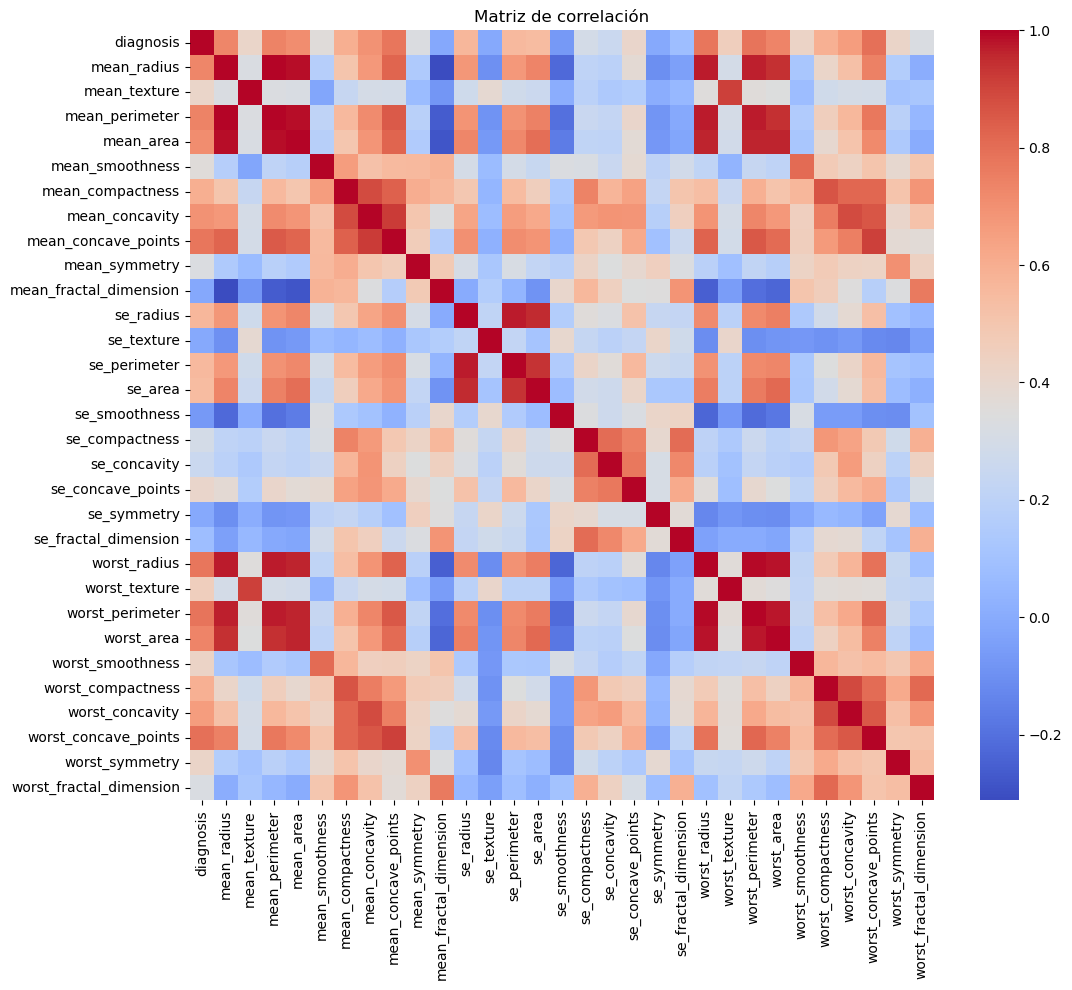

In [30]:
# Matriz de correlación de las características
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Matriz de correlación')
plt.show()

###	3.	Dividir características y etiquetas

Separar las características (X) y las etiquetas (y):

In [18]:
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

In [19]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Implementación honesta

In [20]:

# Definir la clase PreprocessingStep que solo realiza el preprocesamiento en los datos de entrenamiento
class PreprocessingStep(BaseEstimator, TransformerMixin):
    def __init__(self, k=10):
        self.k = k  # Número de características a seleccionar
    
    def fit(self, X, y=None):
        # Solo ajustamos el preprocesador sobre los datos de entrenamiento
        self.imputer = SimpleImputer(strategy='mean')
        self.discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal')
        self.selector = SelectKBest(score_func=f_classif, k=self.k)
        self.selector.fit(X, y) # Selector de caracteristicas
        self.imputer.fit(X)  # Imputamos 
        self.discretizer.fit(X)  # Discretizamos
        return self

    def transform(self, X):
        # Transformamos los datos de acuerdo a lo aprendido en la fase de entrenamiento
        X = self.imputer.transform(X)  # Aplicamos imputación
        X = self.discretizer.transform(X)  # Aplicamos discretización
        X = self.selector.transform(X)  # Selección de características
        return X

# Crear el pipeline para la validación honesta
pipeline_honesto = Pipeline([
    ('preprocess', PreprocessingStep()),  # Paso de preprocesamiento
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Realizar validación cruzada honesta - 10 folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Usamos cross_validate para obtener múltiples métricas
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

results = cross_validate(pipeline_honesto, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)

# Imprimir los resultados
print("Resultados de la validación cruzada:")

# Mostrar las métricas
print(f"Accuracy: {np.mean(results['test_accuracy'])}")
print(f"Precision: {np.mean(results['test_precision'])}")
print(f"Recall: {np.mean(results['test_recall'])}")
print(f"F1-score: {np.mean(results['test_f1'])}")
print(f"AUC-ROC: {np.mean(results['test_roc_auc'])}")



Resultados de la validación cruzada:
Accuracy: 0.9142512077294687
Precision: 0.8994945946726134
Recall: 0.8640827335718976
F1-score: 0.8785505861241155
AUC-ROC: 0.9168061970081892


In [21]:
# Ahora, entrenamos el modelo sobre todo el conjunto de entrenamiento y evaluamos en el conjunto de test
# Entrenar el pipeline sobre los datos de entrenamiento
pipeline_honesto.fit(X_train, y_train)

# Realizamos las predicciones en el conjunto de test
y_pred = pipeline_honesto.predict(X_test)

# Evaluar las métricas en el conjunto de test
test_accuracy_honesto = accuracy_score(y_test, y_pred)
test_precision_honesto = precision_score(y_test, y_pred)
test_recall_honesto = recall_score(y_test, y_pred)
test_f1_honesto = f1_score(y_test, y_pred)
test_roc_auc_honesto = roc_auc_score(y_test, y_pred)

# Imprimir las métricas sobre el conjunto de test
print("\nEvaluación en el conjunto de test <HONESTO>:")
print(f"Accuracy (test): {test_accuracy_honesto}")
print(f"Precision (test): {test_precision_honesto}")
print(f"Recall (test): {test_recall_honesto}")
print(f"F1-score (test): {test_f1_honesto}")
print(f"AUC-ROC (test): {test_roc_auc_honesto}")

# Calcular y mostrar la matriz de confusión
conf_matrix_honesto = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusión en el conjunto de test:")
print(conf_matrix_honesto)


Evaluación en el conjunto de test <HONESTO>:
Accuracy (test): 0.9122807017543859
Precision (test): 0.8837209302325582
Recall (test): 0.8837209302325582
F1-score (test): 0.8837209302325582
AUC-ROC (test): 0.9066491975106452

Matriz de confusión en el conjunto de test:
[[66  5]
 [ 5 38]]


## Implementación NO Honesta

In [22]:
# Definición del pipeline "no honesto"
pipeline_no_honesto = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),              # Imputación
    ('discretizer', KBinsDiscretizer(n_bins=5, encode='ordinal')),  # Discretización
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)),  # Selección de variables
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Validación cruzada 10-fold
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Usamos cross_validate para obtener múltiples métricas
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

results = cross_validate(pipeline_no_honesto, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)

# Imprimir los resultados
print("Resultados de la validación cruzada:")

# Mostrar las métricas
print(f"Accuracy: {np.mean(results['test_accuracy'])}")
print(f"Precision: {np.mean(results['test_precision'])}")
print(f"Recall: {np.mean(results['test_recall'])}")
print(f"F1-score: {np.mean(results['test_f1'])}")
print(f"AUC-ROC: {np.mean(results['test_roc_auc'])}")


Resultados de la validación cruzada:
Accuracy: 0.9077294685990338
Precision: 0.8797326899107084
Recall: 0.8718447857611944
F1-score: 0.8724872251071941
AUC-ROC: 0.8990715059404737


In [23]:

# Entrenar el pipeline sobre los datos de entrenamiento
pipeline_no_honesto.fit(X_train, y_train)

# Realizamos las predicciones en el conjunto de test
y_pred = pipeline_no_honesto.predict(X_test)

# Evaluar las métricas en el conjunto de test
test_accuracy_no_honesto = accuracy_score(y_test, y_pred)
test_precision_no_honesto = precision_score(y_test, y_pred)
test_recall_no_honesto = recall_score(y_test, y_pred)
test_f1_no_honesto = f1_score(y_test, y_pred)
test_roc_auc_no_honesto = roc_auc_score(y_test, y_pred)

# Imprimir las métricas sobre el conjunto de test
print("\nEvaluación en el conjunto de test (no honesto):")
print(f"Accuracy (test): {test_accuracy_no_honesto}")
print(f"Precision (test): {test_precision_no_honesto}")
print(f"Recall (test): {test_recall_no_honesto}")
print(f"F1-score (test): {test_f1_no_honesto}")
print(f"AUC-ROC (test): {test_roc_auc_no_honesto}")

# Calcular y mostrar la matriz de confusión
conf_matrix_no_honesto = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusión en el conjunto de test <NO HONESTO>:")
print(conf_matrix_no_honesto)


Evaluación en el conjunto de test (no honesto):
Accuracy (test): 0.9473684210526315
Precision (test): 0.8936170212765957
Recall (test): 0.9767441860465116
F1-score (test): 0.9333333333333332
AUC-ROC (test): 0.9531608254176219

Matriz de confusión en el conjunto de test <NO HONESTO>:
[[66  5]
 [ 1 42]]


## Visualizacion de resultados

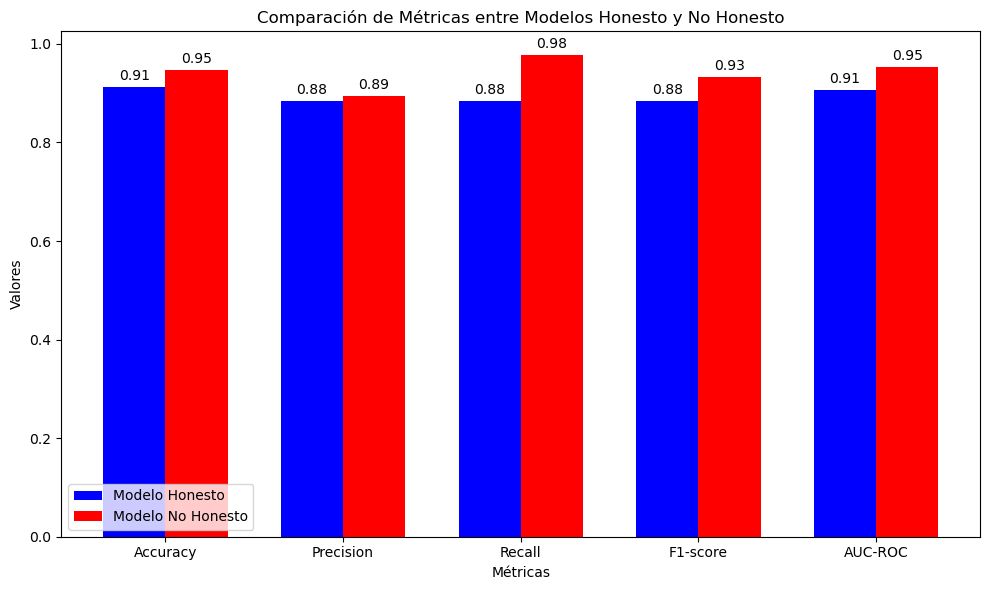

In [24]:
# Resultados obtenidos de ambos modelos (por ejemplo, ya calculados previamente)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']

# Resultados del modelo honesto
honesto_scores = [test_accuracy_honesto, test_precision_honesto, test_recall_honesto, test_f1_honesto, test_roc_auc_honesto]

# Resultados del modelo no honesto
no_honesto_scores = [test_accuracy_no_honesto, test_precision_no_honesto, test_recall_no_honesto, test_f1_no_honesto, test_roc_auc_no_honesto]

# Configuración de la figura y el gráfico
x = np.arange(len(metrics))  # Ubicación de las etiquetas en el eje X
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

# Crear las barras para ambos modelos
rects1 = ax.bar(x - width/2, honesto_scores, width, label='Modelo Honesto', color='blue')
rects2 = ax.bar(x + width/2, no_honesto_scores, width, label='Modelo No Honesto', color='red')

# Añadir etiquetas, título y leyenda
ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparación de Métricas entre Modelos Honesto y No Honesto')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Función para agregar las etiquetas de las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento de la etiqueta
                    textcoords="offset points",
                    ha='center', va='bottom')

# Añadir las etiquetas en cada barra
add_labels(rects1)
add_labels(rects2)

# Mostrar el gráfico
plt.tight_layout()
plt.show()